In [ ]:
import gc
import math
import sys
sys.path.append("../../pytorch-forecasting")
sys.path.append('../')

import pytorch_lightning as pl
import seaborn as sns
import torch
from data_factory.dataLoader import StockPricesLoader
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from utilities import *
import pandas as pd
from tqdm.notebook import tqdm

from data_factory.prepared_data import TimeSeriesData, PreparedData
import math
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer

sns.set_style("whitegrid")
tqdm.pandas()

import matplotlib.pyplot as plt

pl.seed_everything(42)

In [ ]:
config = load_config("../config/config.yml")
assert config['model'] == 'temporal_fusion_transformer', 'Invalid model in file configuration for this script'
model = config['model']
model_config = config[model]

data_ts: TimeSeriesData = TimeSeriesData.from_file('../data/save/timeseries_data.pkl')
data: PreparedData = PreparedData.from_file('../data/save/augmented_data.pkl')

max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']



In [ ]:
# Free RAM by removing useless data

data.train.drop(columns=data.train.columns[pd.Series(data.train.columns).str.contains('ewm')], inplace=True)
data.train.drop(columns=data.train.columns[pd.Series(data.train.columns).str.contains('diff')], inplace=True)
data.val.drop(columns=data.train.columns[pd.Series(data.train.columns).str.contains('ewm')], inplace=True)
data.val.drop(columns=data.train.columns[pd.Series(data.train.columns).str.contains('diff')], inplace=True)
data.test.drop(columns=data.train.columns[pd.Series(data.train.columns).str.contains('ewm')], inplace=True)
data.test.drop(columns=data.train.columns[pd.Series(data.train.columns).str.contains('diff')], inplace=True)




#### load model

In [ ]:
trainer = pl.Trainer(accelerator='gpu', max_epochs=-1)

model = TemporalFusionTransformer.load_from_checkpoint('./model.ckpt')

#### Recreate dataloaders

In [ ]:
# Training
train_dl = data_ts.train.to_dataloader(train=True, batch_size=batch_size, num_workers=12)


# Validation
val_dl = data_ts.val.to_dataloader(train=False, batch_size=batch_size, num_workers=12, shuffle=False)


# Testing
test_dl = data_ts.test.to_dataloader(
    batch_size=data_ts.test_set_size,
    num_workers=6,
    shuffle=False
)

In [5]:
# Training
train_dl = data_ts.train.to_dataloader(train=True, batch_size=batch_size, num_workers=12)


# Validation
val_dl = data_ts.val.to_dataloader(train=False, batch_size=batch_size, num_workers=12, shuffle=False)


# Testing
test_dl = data_ts.test.to_dataloader(
    batch_size=data_ts.test_set_size,
    num_workers=6,
    shuffle=False
)

#### Results

In [ ]:
import numpy as np

y_true = torch.cat([y for _, (y, _) in tqdm(iter(test_dl))])
y_hat = trainer.predict(model, (X for X, (y, _) in test_dl))

y_hat_np = np.array([i.prediction.numpy() for i in y_hat]).reshape(-1, max_prediction_length, model_config['output_size'])
y_true_np = y_true.cpu().detach().numpy()

y_hat_np.shape, y_true_np.shape

  0%|          | 0/2000 [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:175: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [ ]:
for id in range(100, 200, 50):
    plt.plot(y_true_np[id], linewidth=5)
    plt.plot(y_hat_np[id, :, 3])
    plt.plot(y_hat_np[id, :, 0])
    plt.plot(y_hat_np[id, :, 6])
    plt.show()

In [ ]:
y_true_unscaled = y_true_np.reshape(data.test.SecuritiesCode.unique().size, -1, max_prediction_length).copy()
y_hat_unscaled = y_hat_np.reshape(data.test.SecuritiesCode.unique().size, -1, max_prediction_length * 7).copy()

for i, scaler in enumerate(data.scalers['Close']):
    y_true_unscaled[i] = scaler.inverse_transform(y_true_unscaled[i])
    y_hat_unscaled[i] = scaler.inverse_transform(y_hat_unscaled[i])

y_true_unscaled = y_true_unscaled.reshape(-1, config['temporal_fusion_transformer']['sliding_window']['max_prediction_length'])
y_hat_unscaled = y_hat_unscaled.reshape(-1, config['temporal_fusion_transformer']['sliding_window']['max_prediction_length'], model_config['output_size'])

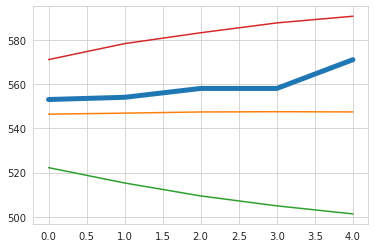

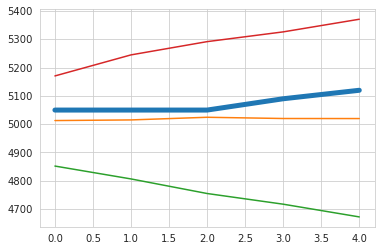

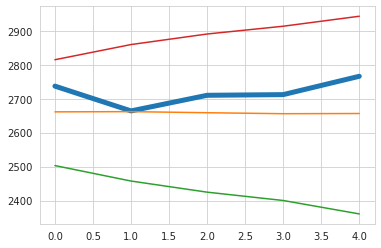

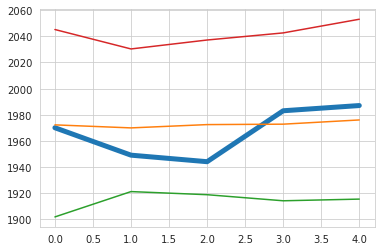

In [15]:
for id in range(100, 2000, 500):
    plt.plot(y_true_unscaled[id], linewidth=5)
    plt.plot(y_hat_unscaled[id, :, 3])
    plt.plot(y_hat_unscaled[id, :, 0])
    plt.plot(y_hat_unscaled[id, :, 6])
    plt.show()

In [16]:
mid_value = math.floor(model_config['output_size'] / 2)
mid_value

3

In [17]:
data.test.columns

Index(['Timestamp', 'RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low',
       'Close', 'Volume', 'AdjustmentFactor',
       ...
       'predict_target_ewm_3_diff1_ewm_5', 'predict_target_ewm_3_diff1_ewm_3',
       'predict_target_ewm_3_diff2_ewm_10', 'predict_target_ewm_3_diff2_ewm_5',
       'predict_target_ewm_3_diff2_ewm_3', 'predict_target_ewm_3_diff3_ewm_10',
       'predict_target_ewm_3_diff3_ewm_5', 'predict_target_ewm_3_diff3_ewm_3',
       'dayofweek', 'Timestamp_1'],
      dtype='object', length=158)

In [18]:
vt = (data.test.is_testing == True)

data.test.loc[vt, 'close_true'] = y_true_np[:, 0].flatten()
data.test.loc[vt, 'close_pred'] = y_hat_np[:, 0, mid_value].flatten()

data.test.loc[vt, 'close_true_unscaled'] = y_true_unscaled[:, 0].flatten()
data.test.loc[vt, 'close_pred_unscaled'] = y_hat_unscaled[:, 0, mid_value].flatten()

data.test.loc[vt, 'target_true'] = (y_true_np[:, 1] - y_true_np[:, 0]) / y_true_np[:, 0]
data.test.loc[vt, 'target_pred'] = (y_hat_np[:, 1, mid_value] - y_hat_np[:, 0, mid_value]) / y_hat_np[:, 0, mid_value]

for i in range(model_config['output_size']):
    data.test.loc[vt, f'close_pred_unscaled_full_{i}'] = pd.Series(list(y_hat_unscaled[:, :, i]), index=data.test[vt].index)

data.test.loc[vt, 'target_true_unscaled'] = (y_true_unscaled[:, 1] - y_true_unscaled[:, 0]) / y_true_unscaled[:, 0]
data.test.loc[vt, 'target_pred_unscaled'] = (y_hat_unscaled[:, 1, mid_value] - y_hat_unscaled[:, 0, mid_value]) / y_hat_unscaled[:, 0, mid_value]

data.test.loc[vt, ['Close', 'close_true_unscaled', 'close_pred_unscaled', 'Target', 'target_true_unscaled', 'target_pred_unscaled']]


/tmp/ipykernel_50167/1121521799.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.test.loc[vt, 'close_true'] = y_true_np[:, 0].flatten()
/tmp/ipykernel_50167/1121521799.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.test.loc[vt, 'close_pred'] = y_hat_np[:, 0, mid_value].flatten()
/tmp/ipykernel_50167/1121521799.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

,Close,close_true_unscaled,close_pred_unscaled,Target,target_true_unscaled,target_pred_unscaled
150,2971.0,3065.0,2958.962891,-0.003263,-0.003263,0.000177
151,3065.0,3055.0,3040.676025,0.009820,0.009820,-0.000176
152,3055.0,3085.0,3056.767334,0.006483,0.006483,-0.000362
153,3085.0,3105.0,3059.113281,-0.006441,-0.006441,0.000040
154,3105.0,3085.0,3081.373047,-0.008104,-0.008104,0.000225
...,...,...,...,...,...,...
421990,727.0,721.0,724.820007,-0.002774,-0.002774,-0.003181
421991,721.0,719.0,712.879272,0.019471,0.019471,0.001069
421992,719.0,733.0,717.476074,0.001364,0.001364,0.002914
421993,733.0,734.0,732.926758,-0.001362,0.000000,0.004005


In [19]:
data.test.loc[vt, ['authentic', 'Timestamp', 'target_true_unscaled', 'Target', 'target_pred_unscaled']]

,authentic,Timestamp,target_true_unscaled,Target,target_pred_unscaled
150,True,18967,-0.003263,-0.003263,0.000177
151,True,18968,0.009820,0.009820,-0.000176
152,True,18969,0.006483,0.006483,-0.000362
153,True,18970,-0.006441,-0.006441,0.000040
154,True,18971,-0.008104,-0.008104,0.000225
...,...,...,...,...,...
421990,True,19044,-0.002774,-0.002774,-0.003181
421991,True,19045,0.019471,0.019471,0.001069
421992,True,19047,0.001364,0.001364,0.002914
421993,True,19048,0.000000,-0.001362,0.004005


In [20]:
dir_true = data.test.target_true > 0
dir_pred = data.test.target_pred > 0


In [21]:
max_prediction_length

5

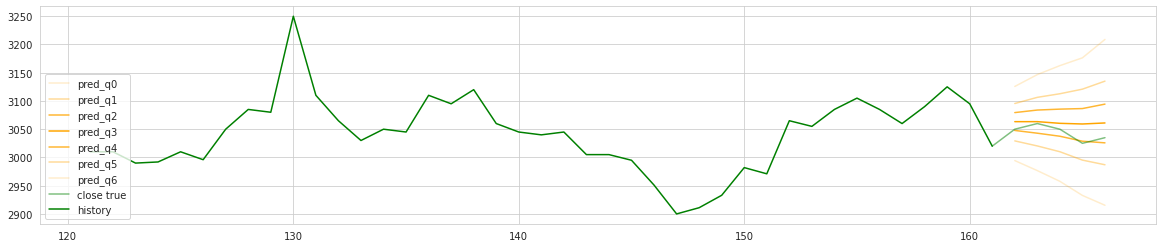

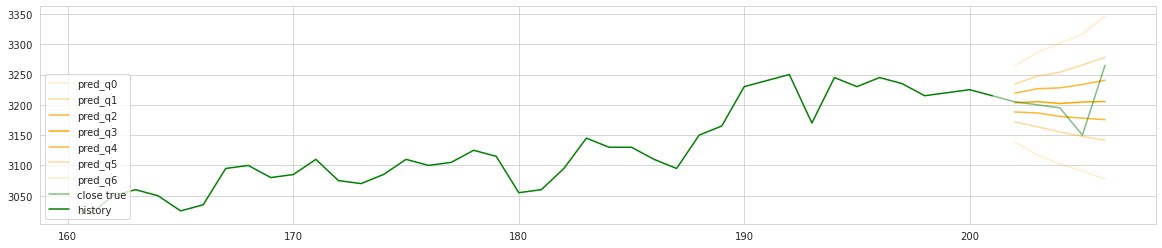

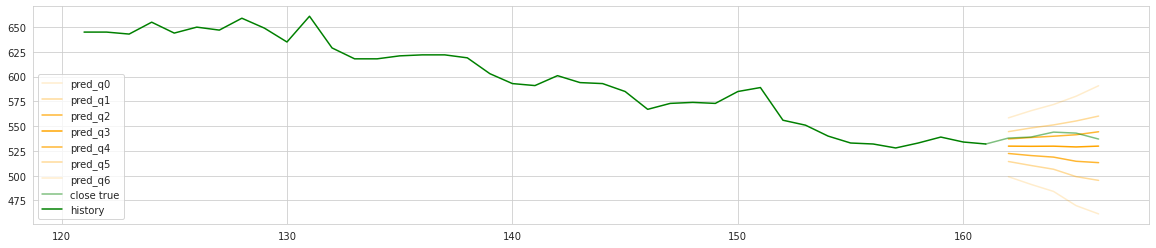

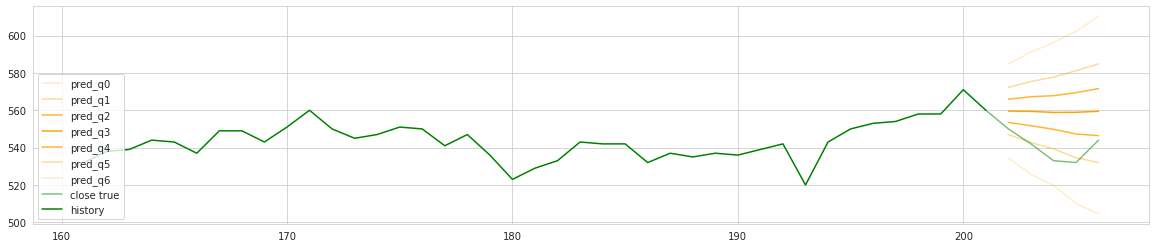

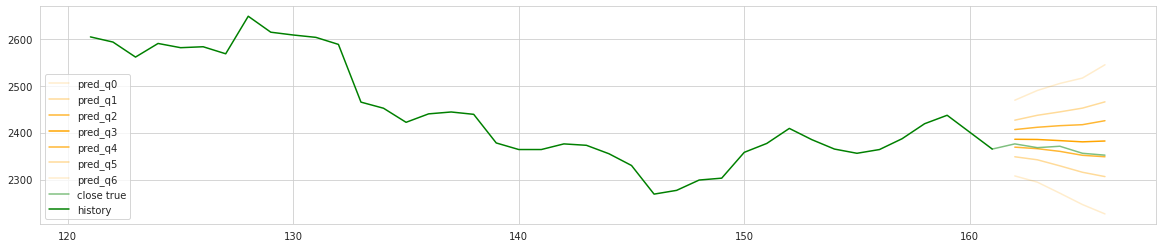

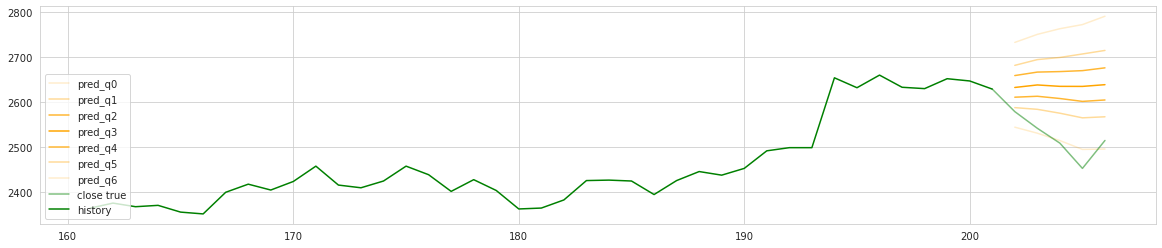

In [22]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd

for sc in data.test.SecuritiesCode.unique()[:3]:
    for start_point in [10, 50]:
        df_full = data.test[(data.test.SecuritiesCode == sc)]
        df_pred = data.test[(data.test.SecuritiesCode == sc) & vt]

        df_pred = df_pred[(df_pred.Timestamp_1 >= df_pred.Timestamp_1.min() + start_point) &
                          (df_pred.Timestamp_1 <= df_pred.Timestamp_1.min() + start_point + max_prediction_length)]
        df_full = df_full[(df_full.Timestamp_1 >= df_pred.Timestamp_1.min() - (max_encoder_length - 110))
                          & (df_full.Timestamp_1 <= df_pred.Timestamp_1.min())]

        figure = plt.figure(figsize=(20, 4))

        for i, a in zip(range(model_config['output_size']), [0.2, .4, .8, 1, .8, .4, .2]):
            plt.plot(df_pred.Timestamp_1.iloc[1:], df_pred[f'close_pred_unscaled_full_{i}'].iloc[0], label=f'pred_q{i}', figure=figure, c='orange', alpha=a)

        plt.plot(df_pred.Timestamp_1, df_pred.Close, label='close true', figure=figure, alpha=.5, c='g')
        # plt.plot(df_pred.Date + datetime.timedelta(days=1), df_pred.close_pred_unscaled, label='close_pred_unscaled', figure=figure, alpha=.5)

        # Plot history
        plt.plot(df_full.Timestamp_1, df_full.Close, label='history', figure=figure, c='g')

        plt.legend(loc='lower left')
        plt.show()

In [23]:
data.test.columns[pd.Series(data.test.columns).str.contains('Time')]

Index(['Timestamp', 'Timestamp_1'], dtype='object')

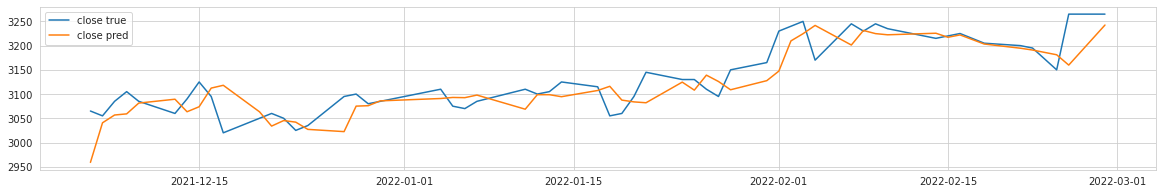

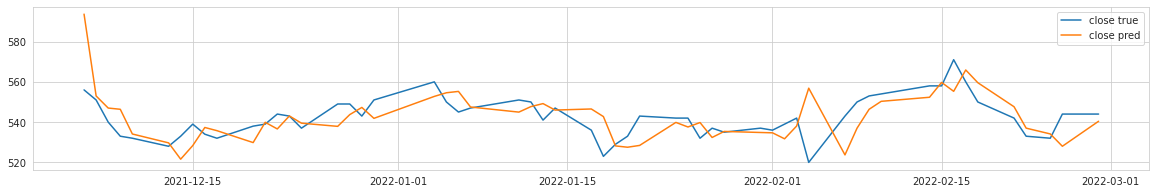

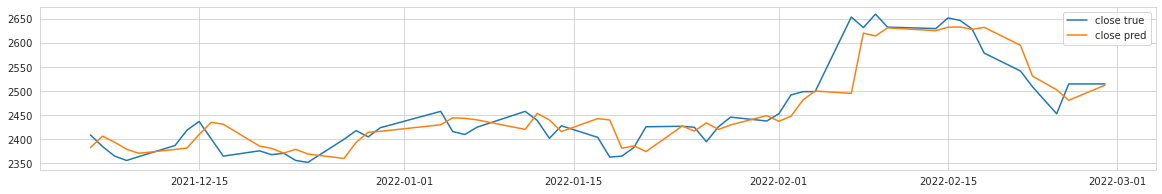

In [24]:
import matplotlib.pyplot as plt

for sc in data.test.SecuritiesCode.unique()[:3]:
    df_pred = data.test[(data.test.SecuritiesCode == sc) & vt]
    figure = plt.figure(figsize=(20, 3))
    # plt.plot(df.Date, df.Close, label='close true', figure=figure)
    plt.plot(df_pred.Date, df_pred.close_true_unscaled, label='close true', figure=figure)
    plt.plot(df_pred.Date, df_pred.close_pred_unscaled, label='close pred', figure=figure)

    plt.legend()
    plt.show()

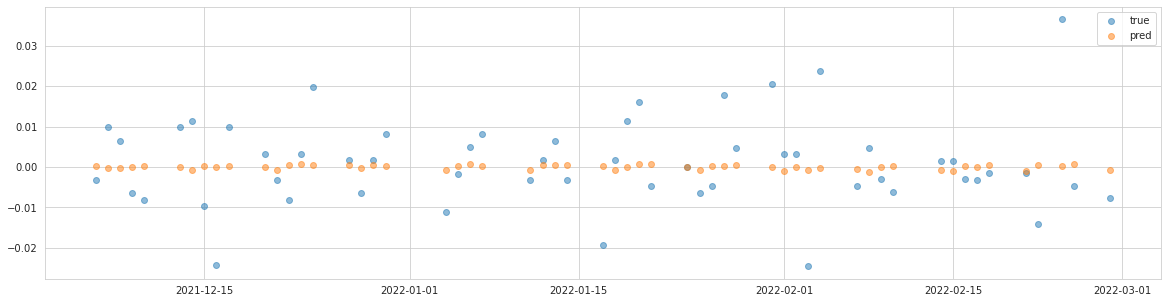

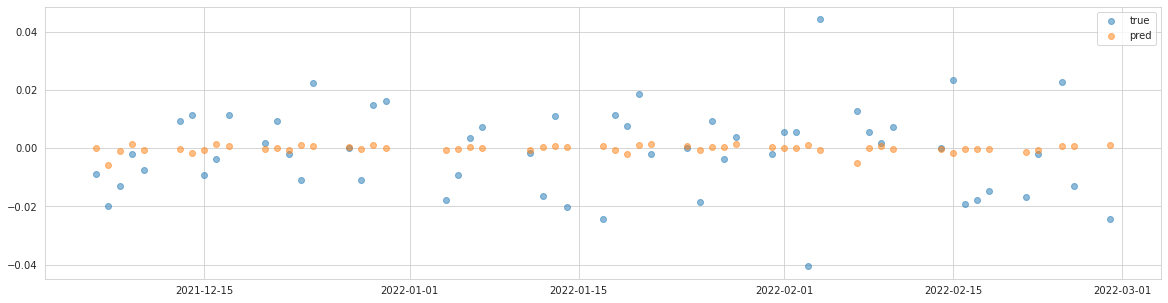

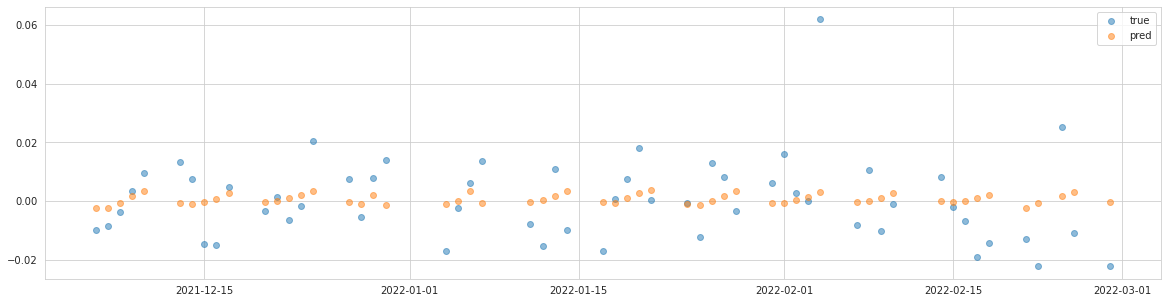

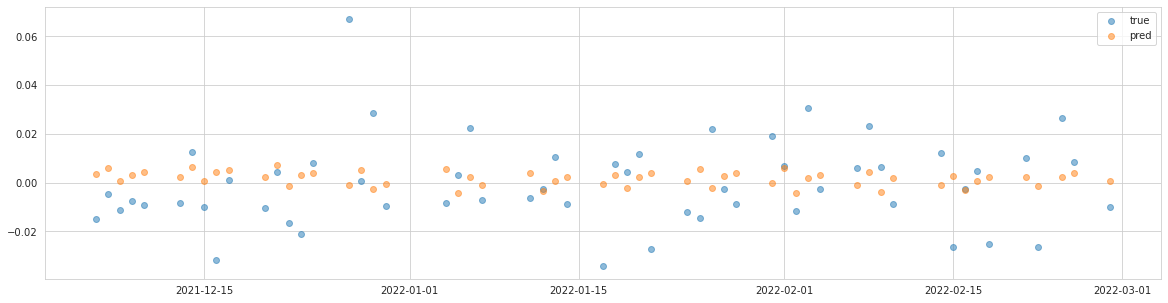

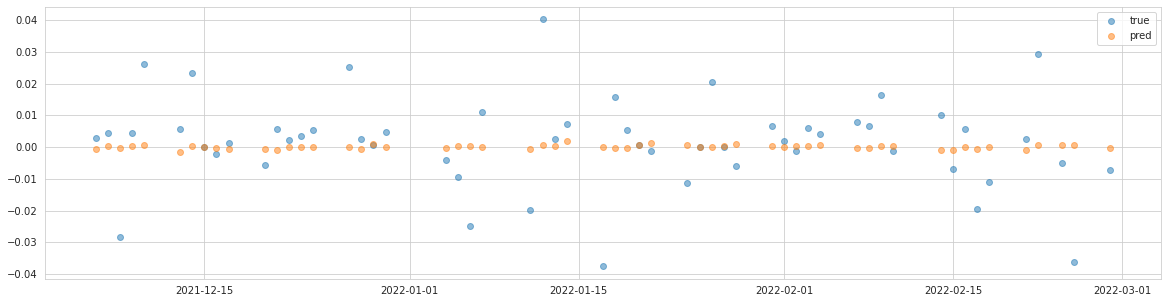

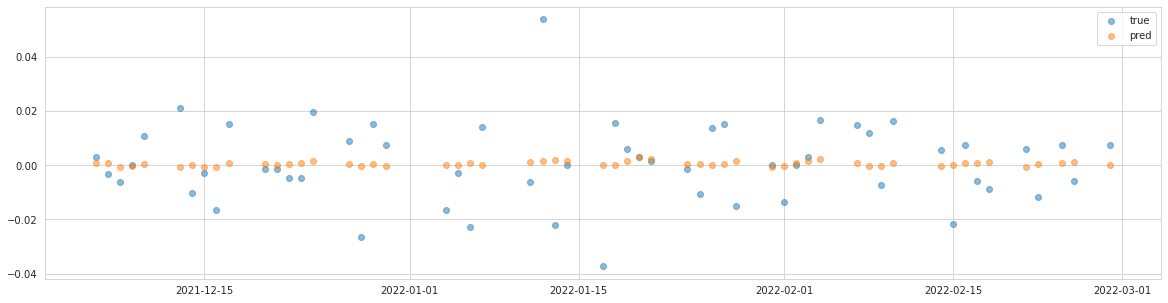

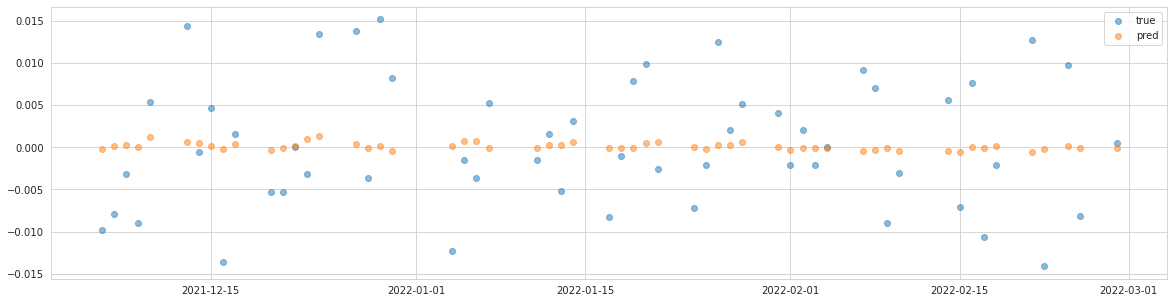

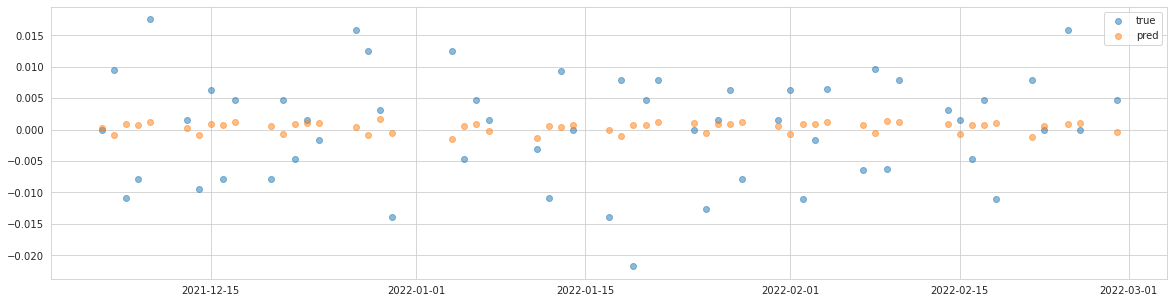

In [25]:
import matplotlib.pyplot as plt

recreated_target_is_valid = data.test.groupby('SecuritiesCode').apply(lambda x: (x.authentic == True).shift(-2).fillna(value=False) & (x.authentic == True).shift(-1).fillna(value=False) & (x.authentic == True)).reset_index(drop=True)
evaluated_target = (data.test.authentic == True) & vt

for sc in data.test.SecuritiesCode.unique()[:8]:
    df_pred = data.test[(data.test.SecuritiesCode == sc) & evaluated_target]
    figure = plt.figure(figsize=(20, 5))
    plt.scatter(df_pred.Date, df_pred.Target, label='true', figure=figure, alpha=.5)
    # plt.scatter(df.Date, df.target_true_unscaled, label='true2', figure=figure, alpha=.5)
    plt.scatter(df_pred.Date, df_pred.target_pred_unscaled, label='pred', figure=figure, alpha=.5)
    plt.legend()
    plt.show()

In [26]:
from utilities.evaluation import calc_spread_return_sharpe

def eval(df):
    return {
        'sharpe': calc_spread_return_sharpe(data.test.loc[vt]),
        'money_gained': df.loc[data.test.Rank < 200].Target.sum() - df.loc[data.test.Rank >= 1800].Target.sum(),
        'true_positive': ((df.loc[data.test.Rank < 200].Target > 0).sum(), (df.loc[data.test.Rank >= 1800].Target <= 0).sum()),
        'false_positive': ((df.loc[data.test.Rank < 200].Target <= 0).sum(), (df.loc[data.test.Rank >= 1800].Target > 0).sum()),
        'true_positive_sum': (df.loc[data.test.Rank < 200].Target > 0).sum() + (df.loc[data.test.Rank >= 1800].Target <= 0).sum(),
        'false_positive_sum': (df.loc[data.test.Rank < 200].Target <= 0).sum() + (df.loc[data.test.Rank >= 1800].Target > 0).sum(),
    }

In [27]:
data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["Target"].rank(ascending=False, method="first") - 1).astype(int)
eval(data.test.loc[vt])

{'sharpe': 5.434704919895069,
 'money_gained': 787.8921722685847,
 'true_positive': (10878, 11167),
 'false_positive': (322, 33),
 'true_positive_sum': 22045,
 'false_positive_sum': 355}

In [28]:
data.test.loc[vt, 'Rank'] = (data.test.loc[vt].groupby("Date")["target_pred_unscaled"].rank(ascending=False, method="first") - 1).astype(int)
eval(data.test.loc[vt]),

({'sharpe': 0.06800314324124679,
  'money_gained': 5.3896445653482274,
  'true_positive': (5105, 6083),
  'false_positive': (6095, 5117),
  'true_positive_sum': 11188,
  'false_positive_sum': 11212},)

#### Experiments

torch.Size([64, 150, 133])


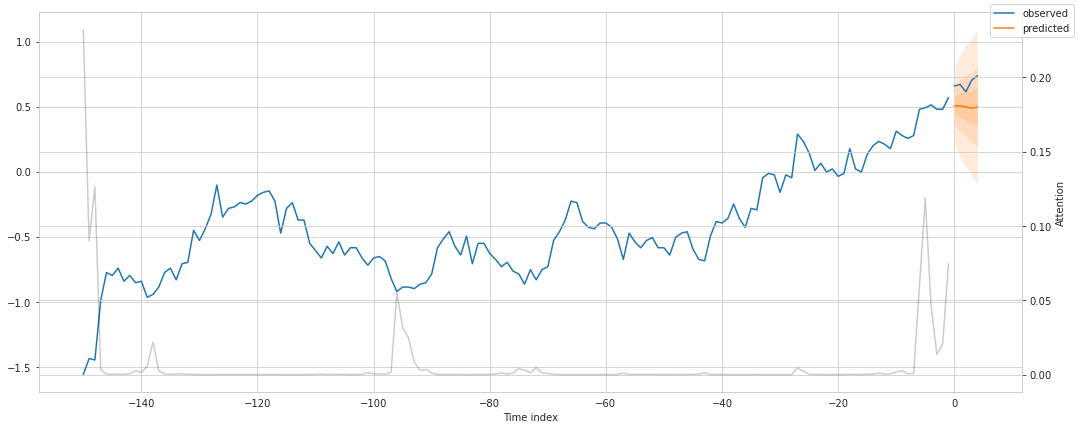

In [29]:
for X, (y, _) in val_dl:
    out = model.forward(X)
    print(X['encoder_cont'].shape)
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    interpretation = model.interpret_output(out, reduction='sum')
    # model.plot_interpretation(interpretation)
    model.plot_prediction(X, out, idx=60, ax=ax)
    break

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manage

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/cyprien/anaconda3/envs/pytorch/lib/pyt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOS.ttf', name='Khmer OS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Yrsa-SemiBoldItalic.ttf', name='Yrsa', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(Fo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-yrsa-rasa/Rasa-SemiBold.ttf', name='Rasa', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari.ttf', name='Kinnari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ponnala.ttf', name='Ponnala', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lib

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-bengali/Lohit-Bengali.ttf', name='Lohit Bengali', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Roman.otf', name='C059', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Umpush-LightOblique.ttf', name='Umpush', style='oblique', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/samyak/Samyak-Devanagari.ttf', name='Samyak Devanagari', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/t

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/Ramaraja-Regular.ttf', name='Ramaraja', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/LikhanNormal.ttf', name='Likhan', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf', name='Ubuntu Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf', name='Liberation Sans Narrow', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf', name='DejaVu Math TeX Gyre', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerif.ttf', name='FreeSerif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi-Italic.ttf', name='Norasi', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusSans-Italic.otf', name='Nimbus Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Waree.ttf', name='Waree', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman-BoldItalic.ttf', name='Laksaman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-BoldObl

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/teluguvijayam/PottiSreeramulu.ttf', name='Potti Sreeramulu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/P052-BoldItalic.otf', name='P052', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/NimbusMonoPS-Regular.otf', name='Nimbus Mono PS', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-beng-extra/Mukti.ttf', name='Mukti', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/malayalam/RaghuMalayalamSans-Regular.ttf', name='RaghuMalayalamSans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont:

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x162 with 1 Axes>,
 'encoder_variables': <Figure size 504x2574 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

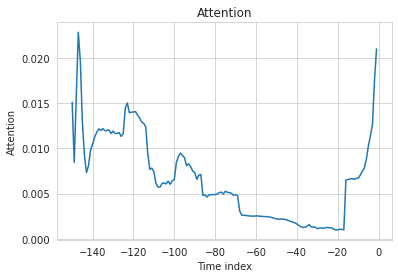

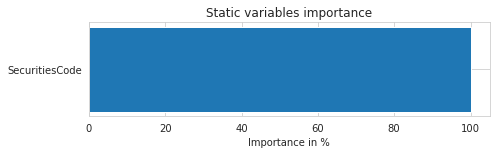

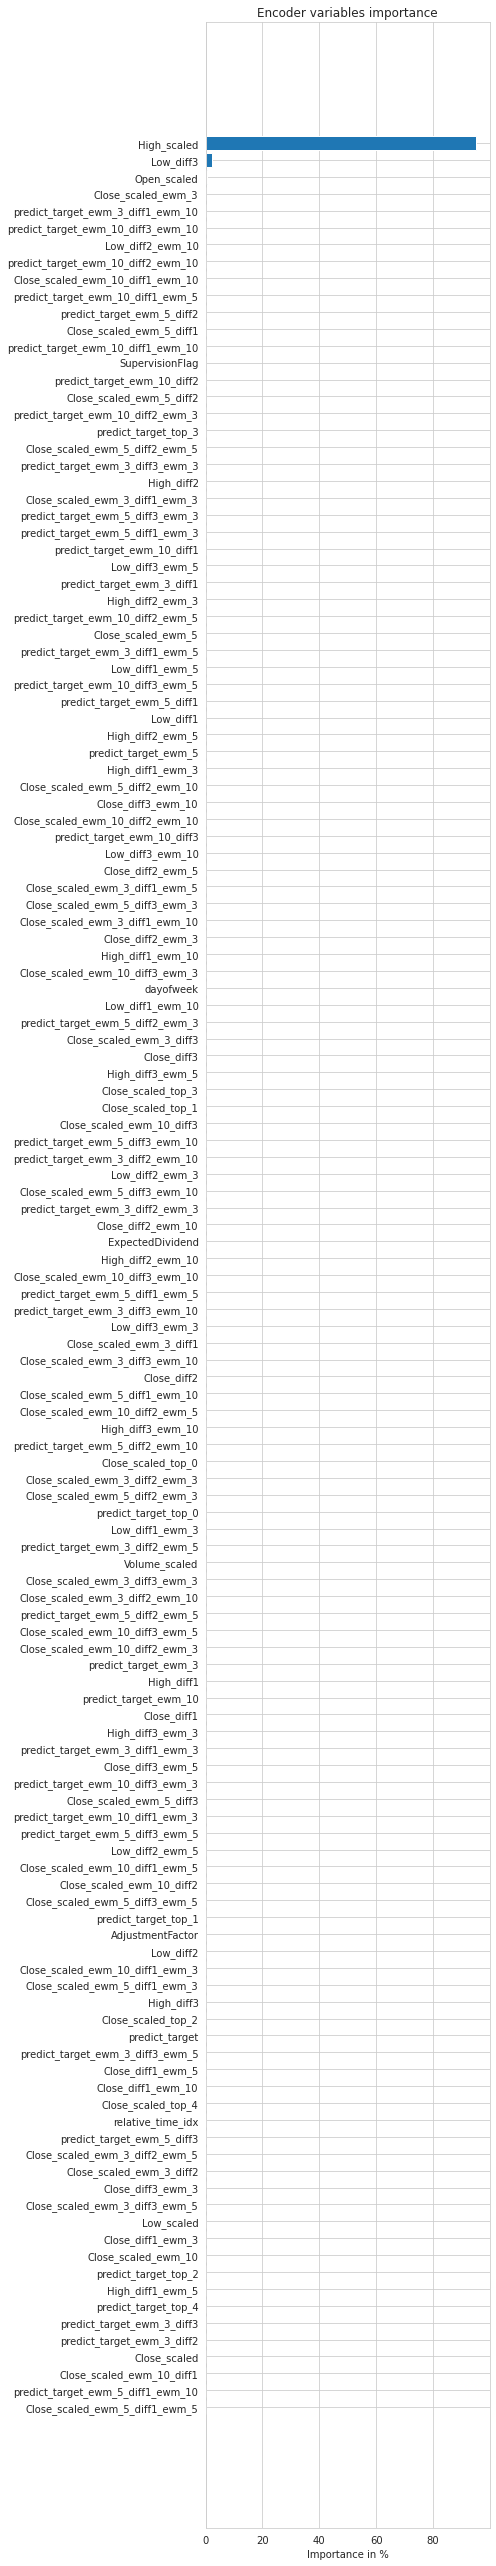

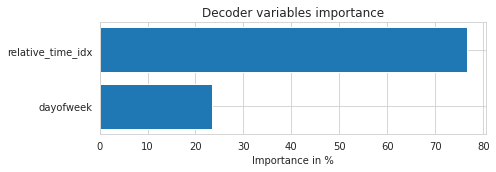

In [30]:
model.plot_interpretation(interpretation)

In [31]:
model.plot_interpretation()

TypeError: plot_interpretation() missing 1 required positional argument: 'interpretation'